In [12]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import lightgbm as lgb
import optuna
import streamlit as st
import plotly
import joblib

print("ALHAMDULILLAH! Semua library berhasil di-load.")
print(f"Pandas version: {pd.__version__}")
print(f"LightGBM version: {lgb.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")
print(f"Optuna version: {optuna.__version__}")
print(f"Streamlit version: {st.__version__}")

ALHAMDULILLAH! Semua library berhasil di-load.
Pandas version: 2.3.3
LightGBM version: 4.6.0
Scikit-learn version: 1.8.0
Optuna version: 4.6.0
Streamlit version: 1.52.1


In [13]:
import os

file_path = r'E:\airta drafts\PREDIKSI KADAR HB\data\raw\erm_hd.xlsx'

try:
    df = pd.read_excel(file_path)
    display(df.head())

    print("\n Informasi Dataset:")
    df.info()

except Exception as e:
    print(f"Terjadi kesalahan: {e}")

,id_pasien,jenis_kelamin,tgl_lahir,tgl_pemeriksaan,eritrosit,hematokrit,MCHC,MCH,MCV,hemoglobin,leukosit,trombosit,status_epo
0,1,P,1965-07-04,2025-03-01,2.8,25.4,33.9,30.2,89.4,8.6,7830,309000,TIDAK
1,1,P,1965-07-04,2025-04-02,2.7,24.3,33.3,29.7,88.9,8.1,7150,262000,TIDAK
2,1,P,1965-07-04,2025-05-03,2.8,24.5,33.9,29.8,88.4,8.3,8070,297000,TIDAK
3,1,P,1965-07-04,2025-06-04,2.7,24.0,32.9,29.2,88.6,7.9,7960,291000,TIDAK
4,1,P,1965-07-04,2025-07-02,2.5,22.5,33.3,29.7,89.5,7.5,7860,307000,TIDAK



 Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id_pasien        829 non-null    int64  
 1   jenis_kelamin    829 non-null    object 
 2   tgl_lahir        829 non-null    object 
 3   tgl_pemeriksaan  829 non-null    object 
 4   eritrosit        829 non-null    object 
 5   hematokrit       829 non-null    object 
 6   MCHC             829 non-null    object 
 7   MCH              829 non-null    object 
 8   MCV              829 non-null    object 
 9   hemoglobin       829 non-null    float64
 10  leukosit         828 non-null    object 
 11  trombosit        828 non-null    object 
 12  status_epo       829 non-null    object 
dtypes: float64(1), int64(1), object(11)
memory usage: 84.3+ KB


In [14]:
df_clean = df.copy()

#1. KONVERSI DATATYPE
cols_numeric = ['eritrosit', 'hematokrit', 'MCHC', 'MCH', 'MCV', 'hemoglobin', 'leukosit', 'trombosit']

for col in cols_numeric:
    df_clean[col] = pd.to_numeric(df_clean[col].astype(str).str.strip().str.replace(',', '.'), errors='coerce')

#KONVERSI TGL_LAHIR KE USIA (INTEGER)
df_clean['tgl_lahir'] = pd.to_datetime(df_clean['tgl_lahir'], errors='coerce')
df_clean['tgl_pemeriksaan'] = pd.to_datetime(df_clean['tgl_pemeriksaan'], errors='coerce')

#Hitung selisih tahun secara akurat (integer bulat)
df_clean['usia'] = ((df_clean['tgl_pemeriksaan'] - df_clean['tgl_lahir']).dt.days / 365.25).fillna(0).astype(int)

#Mengatur posisi kolom usia tepat setelah tgl_lahir
cols = df_clean.columns.tolist()
idx = cols.index('tgl_lahir')
cols.insert(idx + 1, cols.pop(cols.index('usia')))
df_clean = df_clean[cols]

#2. HANDLING MISSING VALUES (RATA-RATA PER FITUR)
# Mengisi nilai kosong dengan rata-rata masing-masing kolom hematologi
for col in cols_numeric:
    rata_rata = df_clean[col].mean()
    df_clean[col] = df_clean[col].fillna(rata_rata)

# Khusus leukosit dan trombosit, DIbulatkan kembali ke Integer setelah imputasi
cols_int = ['leukosit', 'trombosit']
for col in cols_int:
    df_clean[col] = df_clean[col].round().astype('Int64')


#3. BINERISASI STATUS EPO
mapping_epo = {'TIDAK': 0, 'YA': 1}
df_clean['epo'] = df_clean['status_epo'].map(mapping_epo)

# Mengatur posisi status_epo_biner tepat setelah status_epo
cols = df_clean.columns.tolist()
idx_epo = cols.index('status_epo')
cols.insert(idx_epo + 1, cols.pop(cols.index('epo')))
df_clean = df_clean[cols]

#4. BINERISASI JENIS KELAMIN
mapping_jk = {'P': 0, 'L': 1}
df_clean['jk'] = df_clean['jenis_kelamin'].map(mapping_jk)

# Mengatur posisi jenis_kelamin_biner tepat setelah jenis_kelamin
cols = df_clean.columns.tolist()
idx_jk = cols.index('jenis_kelamin')
cols.insert(idx_jk + 1, cols.pop(cols.index('jk')))
df_clean = df_clean[cols]

In [15]:
df_clean.info()

print("Cuplikan 12 Baris Pertama Dataset Raw:")
display(df.head(12))

print("Cuplikan 12 Baris Pertama Dataset Clean:")
display(df_clean.head(12))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id_pasien        829 non-null    int64         
 1   jenis_kelamin    829 non-null    object        
 2   jk               829 non-null    int64         
 3   tgl_lahir        829 non-null    datetime64[ns]
 4   usia             829 non-null    int64         
 5   tgl_pemeriksaan  829 non-null    datetime64[ns]
 6   eritrosit        829 non-null    float64       
 7   hematokrit       829 non-null    float64       
 8   MCHC             829 non-null    float64       
 9   MCH              829 non-null    float64       
 10  MCV              829 non-null    float64       
 11  hemoglobin       829 non-null    float64       
 12  leukosit         829 non-null    Int64         
 13  trombosit        829 non-null    Int64         
 14  status_epo       829 non-null    object   

,id_pasien,jenis_kelamin,tgl_lahir,tgl_pemeriksaan,eritrosit,hematokrit,MCHC,MCH,MCV,hemoglobin,leukosit,trombosit,status_epo
0,1,P,1965-07-04,2025-03-01,2.8,25.4,33.9,30.2,89.4,8.6,7830,309000,TIDAK
1,1,P,1965-07-04,2025-04-02,2.7,24.3,33.3,29.7,88.9,8.1,7150,262000,TIDAK
2,1,P,1965-07-04,2025-05-03,2.8,24.5,33.9,29.8,88.4,8.3,8070,297000,TIDAK
3,1,P,1965-07-04,2025-06-04,2.7,24.0,32.9,29.2,88.6,7.9,7960,291000,TIDAK
4,1,P,1965-07-04,2025-07-02,2.5,22.5,33.3,29.7,89.5,7.5,7860,307000,TIDAK
5,1,P,1965-07-04,2025-08-02,2.7,24.2,32.6,29.5,89.7,7.9,9600,315000,TIDAK
6,1,P,1965-07-04,2025-08-23,2.9,25.2,32.1,28.6,88.4,7.9,9510,352000,TIDAK
7,1,P,1965-07-04,2025-09-03,3.3,29.3,32.4,28.4,87.6,9.5,8710,343000,TIDAK
8,1,P,1965-07-04,2025-10-01,3.2,28.0,32.9,28.6,87.2,9.1,9860,269000,TIDAK
9,1,P,1965-07-04,2025-11-01,3.1,27.0,32.2,28.3,88.1,8.7,10140,285000,TIDAK


Cuplikan 12 Baris Pertama Dataset Clean:


,id_pasien,jenis_kelamin,jk,tgl_lahir,usia,tgl_pemeriksaan,eritrosit,hematokrit,MCHC,MCH,MCV,hemoglobin,leukosit,trombosit,status_epo,epo
0,1,P,0,1965-07-04,59,2025-03-01,2.8,25.4,33.900000,30.200000,89.400000,8.6,7830,309000,TIDAK,0
1,1,P,0,1965-07-04,59,2025-04-02,2.7,24.3,33.300000,29.700000,88.900000,8.1,7150,262000,TIDAK,0
2,1,P,0,1965-07-04,59,2025-05-03,2.8,24.5,33.900000,29.800000,88.400000,8.3,8070,297000,TIDAK,0
3,1,P,0,1965-07-04,59,2025-06-04,2.7,24.0,32.900000,29.200000,88.600000,7.9,7960,291000,TIDAK,0
4,1,P,0,1965-07-04,59,2025-07-02,2.5,22.5,33.300000,29.700000,89.500000,7.5,7860,307000,TIDAK,0
5,1,P,0,1965-07-04,60,2025-08-02,2.7,24.2,32.600000,29.500000,89.700000,7.9,9600,315000,TIDAK,0
6,1,P,0,1965-07-04,60,2025-08-23,2.9,25.2,32.100000,28.600000,88.400000,7.9,9510,352000,TIDAK,0
7,1,P,0,1965-07-04,60,2025-09-03,3.3,29.3,32.400000,28.400000,87.600000,9.5,8710,343000,TIDAK,0
8,1,P,0,1965-07-04,60,2025-10-01,3.2,28.0,32.900000,28.600000,87.200000,9.1,9860,269000,TIDAK,0
9,1,P,0,1965-07-04,60,2025-11-01,3.1,27.0,32.200000,28.300000,88.100000,8.7,10140,285000,TIDAK,0


In [16]:
df_clean = df_clean.drop(columns=['tgl_lahir', 'status_epo', 'jenis_kelamin'])
print(f"Kolom saat ini: {df_clean.columns.tolist()}")

Kolom saat ini: ['id_pasien', 'jk', 'usia', 'tgl_pemeriksaan', 'eritrosit', 'hematokrit', 'MCHC', 'MCH', 'MCV', 'hemoglobin', 'leukosit', 'trombosit', 'epo']


In [17]:
#5. AGGREGATION PER BULAN
df_clean['tgl_pemeriksaan'] = pd.to_datetime(df_clean['tgl_pemeriksaan'])

cols_to_mean = ['usia', 'jk', 'eritrosit', 'hematokrit', 'MCHC', 'MCH', 'MCV', 
                'hemoglobin', 'leukosit', 'trombosit', 'epo']

#Proses Aggregation: Group by id_pasien dan Resample per Bulan (Month Start / MS)
df_clean = (df_clean.groupby('id_pasien')
            .resample('MS', on='tgl_pemeriksaan')[cols_to_mean]
            .mean()
            .dropna() # Menghapus bulan yang memang tidak ada pemeriksaannya
            .reset_index())

#Kembalikan kolom leukosit, trombosit, dan usia ke tipe Integer
cols_to_int = ['usia', 'jk', 'leukosit', 'trombosit', 'epo']
for col in cols_to_int:
    df_clean[col] = df_clean[col].round().astype('Int64')


print(f"Data berhasil diringkas per bulan.")
display(df_clean.head(10))

Data berhasil diringkas per bulan.


,id_pasien,tgl_pemeriksaan,usia,jk,eritrosit,hematokrit,MCHC,MCH,MCV,hemoglobin,leukosit,trombosit,epo
0,1,2025-03-01,59,0,2.8,25.4,33.90,30.20,89.40,8.6,7830,309000,0
1,1,2025-04-01,59,0,2.7,24.3,33.30,29.70,88.90,8.1,7150,262000,0
2,1,2025-05-01,59,0,2.8,24.5,33.90,29.80,88.40,8.3,8070,297000,0
3,1,2025-06-01,59,0,2.7,24.0,32.90,29.20,88.60,7.9,7960,291000,0
4,1,2025-07-01,59,0,2.5,22.5,33.30,29.70,89.50,7.5,7860,307000,0
5,1,2025-08-01,60,0,2.8,24.7,32.35,29.05,89.05,7.9,9555,333500,0
6,1,2025-09-01,60,0,3.3,29.3,32.40,28.40,87.60,9.5,8710,343000,0
7,1,2025-10-01,60,0,3.2,28.0,32.90,28.60,87.20,9.1,9860,269000,0
8,1,2025-11-01,60,0,3.1,27.0,32.20,28.30,88.10,8.7,10140,285000,0
9,1,2025-12-01,60,0,3.0,26.3,32.70,28.80,87.70,8.6,11750,400000,0


In [18]:
df_clean.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 628 entries, 0 to 627
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id_pasien        628 non-null    int64         
 1   tgl_pemeriksaan  628 non-null    datetime64[ns]
 2   usia             628 non-null    Int64         
 3   jk               628 non-null    Int64         
 4   eritrosit        628 non-null    float64       
 5   hematokrit       628 non-null    float64       
 6   MCHC             628 non-null    float64       
 7   MCH              628 non-null    float64       
 8   MCV              628 non-null    float64       
 9   hemoglobin       628 non-null    float64       
 10  leukosit         628 non-null    Int64         
 11  trombosit        628 non-null    Int64         
 12  epo              628 non-null    Int64         
dtypes: Int64(5), datetime64[ns](1), float64(6), int64(1)
memory usage: 67.0 KB


In [19]:
# SIMPAN DATA CLEAN erm_hd_clean.xlsx
path_tujuan = r'E:\airta drafts\PREDIKSI KADAR HB\data\processed\erm_hd_clean.xlsx'

df_clean.to_excel(path_tujuan, index=False)
print(f"Data berhasil disimpan ke: {path_tujuan}")

Data berhasil disimpan ke: E:\airta drafts\PREDIKSI KADAR HB\data\processed\erm_hd_clean.xlsx


In [21]:
df_clean['tgl_pemeriksaan'] = pd.to_datetime(df_clean['tgl_pemeriksaan'])
folder_tujuan = os.path.dirname(path_tujuan)
if not os.path.exists(folder_tujuan):
    os.makedirs(folder_tujuan)

# Simpan menggunakan Engine XlsxWriter (Wajib untuk mengatur format tampilan)
with pd.ExcelWriter(path_tujuan, engine='xlsxwriter') as writer:
    df_clean.to_excel(writer, index=False, sheet_name='Sheet1')
    workbook  = writer.book
    worksheet = writer.sheets['Sheet1']
    
    format_tgl = workbook.add_format({'num_format': 'yyyy-mm-dd'})
    idx_tgl = df_clean.columns.get_loc('tgl_pemeriksaan')
    worksheet.set_column(idx_tgl, idx_tgl, 18, format_tgl)

display(data_types)
print(f"Selesai! Sekarang buka file di VS Code, kolom tgl_pemeriksaan sudah normal.")

NameError: name 'data_types' is not defined

In [22]:
# END OF CODE PREPROCESSING

In [23]:
df['tgl_pemeriksaan'] = pd.to_datetime(df['tgl_pemeriksaan'], errors='coerce')

# 1. PEMBUKTIAN DATA TYPE CASTING
print("\n--- PERBANDINGAN TIPE DATA ---")
data_types = pd.DataFrame({
    'Kolom': ['tgl_pemeriksaan', 'eritrosit', 'hematokrit', 'MCH', 'MCHC', 'MCV', 'hemoglobin', 'leukosit', 'trombosit'],
    'Tipe Sebelum': [df['tgl_pemeriksaan'].dtype, df['eritrosit'].dtype, df['hematokrit'].dtype, df['MCH'].dtype, df['MCHC'].dtype, df['MCV'].dtype, df['hemoglobin'].dtype, df['leukosit'].dtype, df['trombosit'].dtype],
    'Tipe Sesudah': [df_clean['tgl_pemeriksaan'].dtype, df_clean['eritrosit'].dtype, df_clean['hematokrit'].dtype, df_clean['MCH'].dtype, df_clean['MCHC'].dtype, df_clean['MCV'].dtype, df_clean['hemoglobin'].dtype, df_clean['leukosit'].dtype, df_clean['trombosit'].dtype]
})
display(data_types)


--- PERBANDINGAN TIPE DATA ---


,Kolom,Tipe Sebelum,Tipe Sesudah
0,tgl_pemeriksaan,datetime64[ns],datetime64[ns]
1,eritrosit,object,float64
2,hematokrit,object,float64
3,MCH,object,float64
4,MCHC,object,float64
5,MCV,object,float64
6,hemoglobin,float64,float64
7,leukosit,object,Int64
8,trombosit,object,Int64


In [24]:
# 2. PEMBUKTIAN FEATURE ENGINEERING (TRANSFORMASI USIA, JENIS KELAMIN, dan STATUS EPO)
print("\n--- TRANSFORMASI USIA & STATUS EPO ---")
print("Contoh Data Mentah Pasien 002:")
cols_before = ['id_pasien', 'tgl_lahir', 'jenis_kelamin', 'status_epo']
df_before = df[df['id_pasien'].astype(str).str.match(r'^(002|2)$')].sort_values('tgl_lahir')
display(df_before[cols_before].head(10))  

print("Contoh Data Terproses (df_clean) Pasien 002:")
# Menampilkan kolom hasil transformasi: usia dan epo (biner)
cols_after = ['id_pasien', 'jk', 'usia', 'epo']
df_after = df_clean[df_clean['id_pasien'].astype(str).str.match(r'^(002|2)$')].head(10)
display(df_after[cols_after])


--- TRANSFORMASI USIA & STATUS EPO ---
Contoh Data Mentah Pasien 002:


,id_pasien,tgl_lahir,jenis_kelamin,status_epo
11,2,1957-07-02,P,TIDAK
12,2,1957-07-02,P,TIDAK
13,2,1957-07-02,P,TIDAK
14,2,1957-07-02,P,TIDAK
15,2,1957-07-02,P,TIDAK
16,2,1957-07-02,P,TIDAK
17,2,1957-07-02,P,TIDAK
18,2,1957-07-02,P,TIDAK
19,2,1957-07-02,P,TIDAK
20,2,1957-07-02,P,TIDAK


Contoh Data Terproses (df_clean) Pasien 002:


,id_pasien,jk,usia,epo
10,2,0,67,0
11,2,0,67,0
12,2,0,67,0
13,2,0,67,0
14,2,0,67,0
15,2,0,68,0
16,2,0,68,0
17,2,0,68,0
18,2,0,68,0
19,2,0,68,0


In [25]:
# 3. PEMBUKTIAN HANDLING MISSING VALUES PADA PASIEN 002
print("--- [BEFORE] DATA MENTAH PASIEN 002 (KONDISI MISSING VALUES) ---")
cols_hematologi = ['eritrosit', 'hematokrit', 'MCV', 'MCH', 'MCHC']
cols_show = ['id_pasien', 'tgl_pemeriksaan'] + cols_hematologi

df_p2_raw = df[df['id_pasien'].astype(str).str.match(r'^(002|2)$')]
display(df_p2_raw[cols_show].head(5))

print("\n" + "="*80 + "\n")
print("--- [AFTER] DATA TERPROSES PASIEN 002 (SUDAH IMPUTASI RATA-RATA) ---")

df_p2_clean = df_clean[df_clean['id_pasien'].astype(str).str.match(r'^(002|2)$')]

display(df_p2_clean[cols_show].head(5))

--- [BEFORE] DATA MENTAH PASIEN 002 (KONDISI MISSING VALUES) ---


,id_pasien,tgl_pemeriksaan,eritrosit,hematokrit,MCV,MCH,MCHC
11,2,2025-02-21,2.6,23.2,-,-,-
12,2,2025-03-01,2.8,25.1,89.9,29.9,33.1
13,2,2025-04-02,2.6,22.8,88.9,30.1,33.8
14,2,2025-05-03,2.6,23.5,89.6,29.9,33.2
15,2,2025-06-04,2.5,22.6,89.5,29.8,33.2




--- [AFTER] DATA TERPROSES PASIEN 002 (SUDAH IMPUTASI RATA-RATA) ---


,id_pasien,tgl_pemeriksaan,eritrosit,hematokrit,MCV,MCH,MCHC
10,2,2025-02-01,2.60,23.2,87.618679,29.097332,33.195934
11,2,2025-03-01,2.80,25.1,89.900000,29.900000,33.100000
12,2,2025-04-01,2.60,22.8,88.900000,30.100000,33.800000
13,2,2025-05-01,2.60,23.5,89.600000,29.900000,33.200000
14,2,2025-06-01,2.65,23.7,89.400000,29.850000,33.350000


In [26]:
#4 PEMBUKTIAN AGREGASI BULANAN
df_p2 = df[df['id_pasien'].astype(str).str.match(r'^(002|2)$')]

print("--- [BEFORE] DATA MENTAH PASIEN 002 (JUNI & SEPTEMBER) ---")
print("Keterangan: Terlihat baris ganda pada bulan yang sama.")
cols_before = ['id_pasien', 'tgl_pemeriksaan', 'tgl_lahir', 'status_epo', 'hemoglobin']

df_before_specific = df_p2[df_p2['tgl_pemeriksaan'].dt.month.isin([6, 9])].sort_values('tgl_pemeriksaan')
display(df_before_specific[cols_before])

print("\n" + "="*80 + "\n")

print("--- [AFTER] DATA AGREGASI BULANAN PASIEN 002 (JUNI & SEPTEMBER) ---")
print("Keterangan: Data sudah diringkas menjadi satu baris per bulan (Rata-rata).")
cols_after = ['id_pasien', 'tgl_pemeriksaan', 'usia', 'epo', 'hemoglobin']

df_clean_p2 = df_clean[df_clean['id_pasien'].astype(str).str.match(r'^(002|2)$')]
df_after_specific = df_clean_p2[df_clean_p2['tgl_pemeriksaan'].dt.month.isin([6, 9])].sort_values('tgl_pemeriksaan')
display(df_after_specific[cols_after])

--- [BEFORE] DATA MENTAH PASIEN 002 (JUNI & SEPTEMBER) ---
Keterangan: Terlihat baris ganda pada bulan yang sama.


,id_pasien,tgl_pemeriksaan,tgl_lahir,status_epo,hemoglobin
15,2,2025-06-04,1957-07-02,TIDAK,7.5
16,2,2025-06-08,1957-07-02,TIDAK,8.3
19,2,2025-09-03,1957-07-02,TIDAK,7.0
20,2,2025-09-04,1957-07-02,TIDAK,7.6
21,2,2025-09-05,1957-07-02,TIDAK,8.9




--- [AFTER] DATA AGREGASI BULANAN PASIEN 002 (JUNI & SEPTEMBER) ---
Keterangan: Data sudah diringkas menjadi satu baris per bulan (Rata-rata).


,id_pasien,tgl_pemeriksaan,usia,epo,hemoglobin
14,2,2025-06-01,67,0,7.900000
17,2,2025-09-01,68,0,7.833333


In [27]:
# Memilih kolom hematologi utama sesuai rencana Anda
cols_hematologi = ['eritrosit', 'hematokrit', 'MCHC', 'MCH', 'MCV', 'hemoglobin', 'leukosit', 'trombosit']

# Menampilkan statistik deskriptif
print("Statistik Deskriptif Variabel Hematologi:")
display(df_clean[cols_hematologi].describe())

Statistik Deskriptif Variabel Hematologi:


,eritrosit,hematokrit,MCHC,MCH,MCV,hemoglobin,leukosit,trombosit
count,628.000000,628.000000,628.000000,628.000000,628.000000,628.000000,628.0,628.0
mean,2.798703,24.422305,33.142100,29.037964,87.582102,8.069498,8255.347134,232512.726115
std,0.436567,3.571667,0.821684,2.124432,5.454127,1.124729,2772.444407,87843.411722
min,1.450000,14.650000,30.800000,19.800000,62.500000,4.900000,1510.0,44000.0
25%,2.500000,22.037500,32.600000,27.800000,85.125000,7.300000,6340.0,173000.0
50%,2.800000,24.200000,33.200000,29.100000,87.626006,8.000000,7815.0,231250.0
75%,3.100000,26.500000,33.750000,30.400000,90.662500,8.700000,9810.25,288000.0
max,4.266667,36.200000,37.100000,34.100000,101.450000,11.700000,24680.0,664000.0


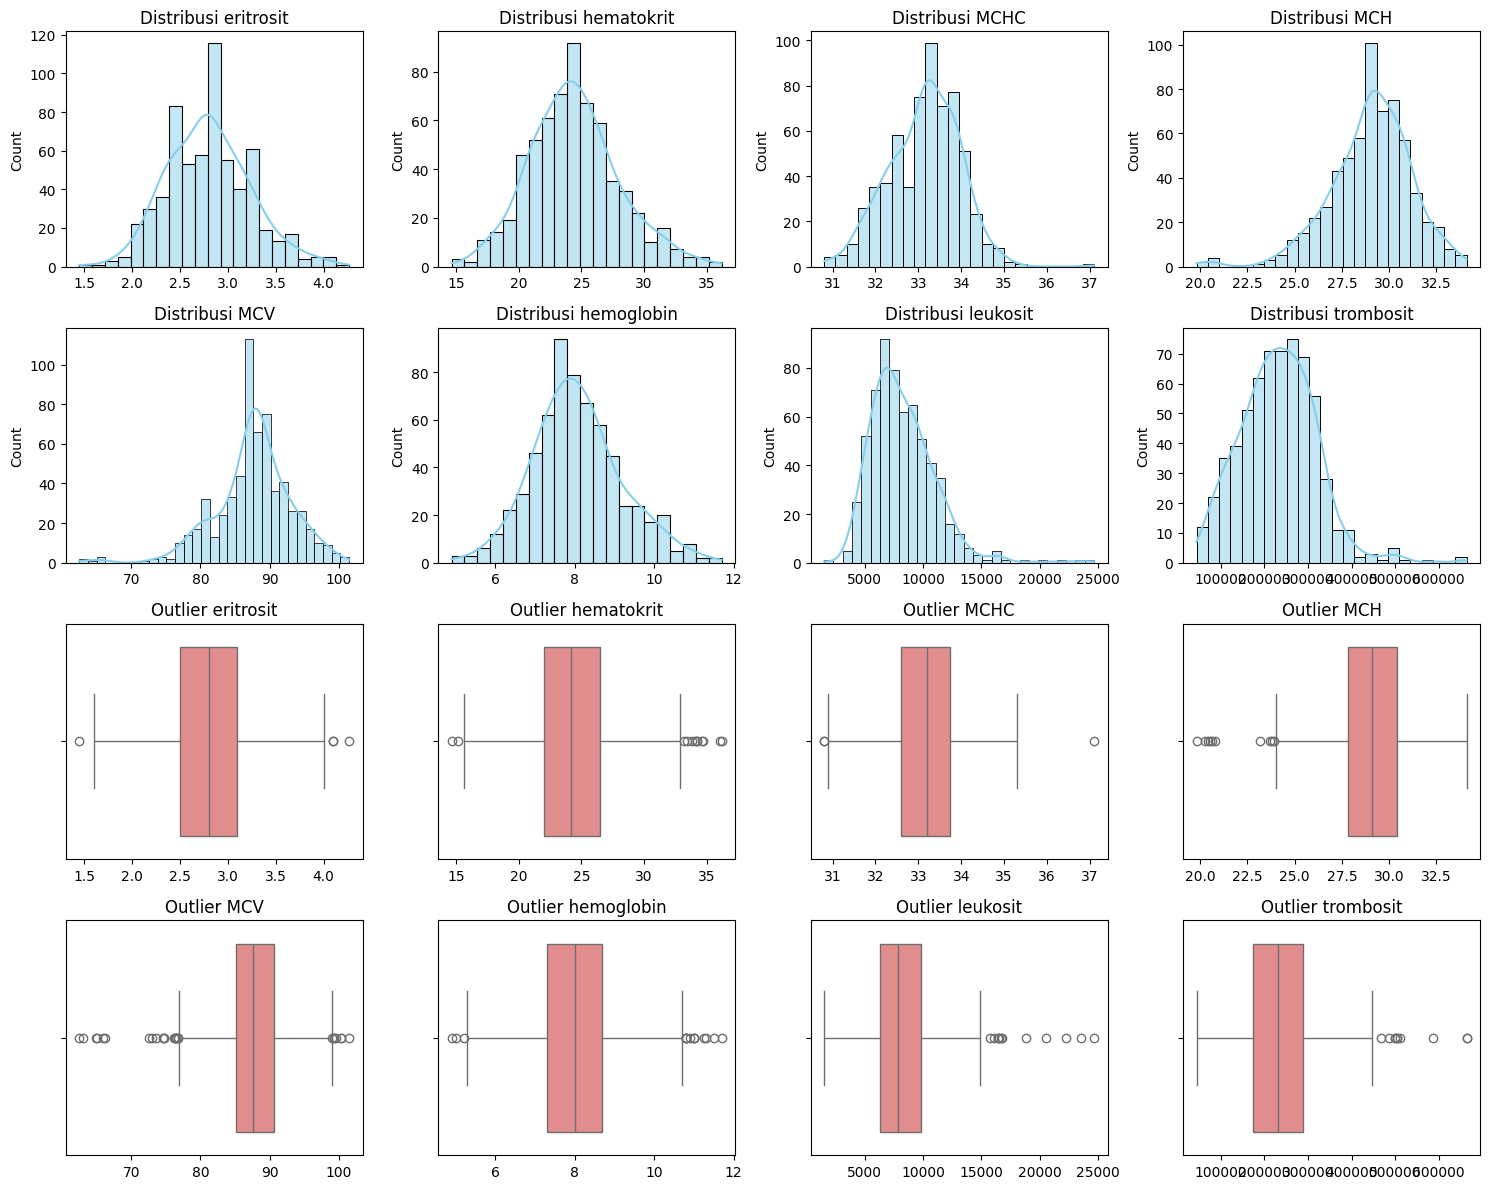

In [28]:
# Membuat figure untuk subplots
plt.figure(figsize=(15, 12))

for i, col in enumerate(cols_hematologi):
    # Histogram (Baris 1 & 2)
    plt.subplot(4, 4, i+1)
    sns.histplot(df_clean[col], kde=True, color='skyblue') # Menggunakan df_clean
    plt.title(f'Distribusi {col}')
    plt.xlabel('')

    # Boxplot (Baris 3 & 4)
    plt.subplot(4, 4, i+9) 
    sns.boxplot(x=df_clean[col], color='lightcoral') # Menggunakan df_clean
    plt.title(f'Outlier {col}')
    plt.xlabel('')

plt.tight_layout()
plt.show()

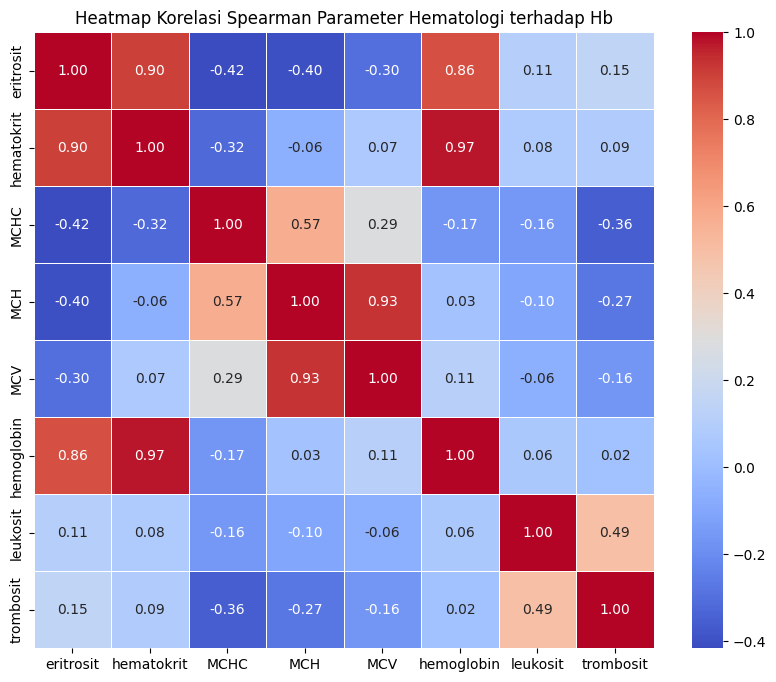

In [29]:
plt.figure(figsize=(10, 8))

# Menghitung korelasi (Spearman)
# Spearman digunakan untuk menangkap hubungan non-linear yang monotonik
correlation_matrix = df_clean[cols_hematologi].corr(method='spearman')

# Visualisasi dengan Heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Heatmap Korelasi Spearman Parameter Hematologi terhadap Hb")
plt.show()

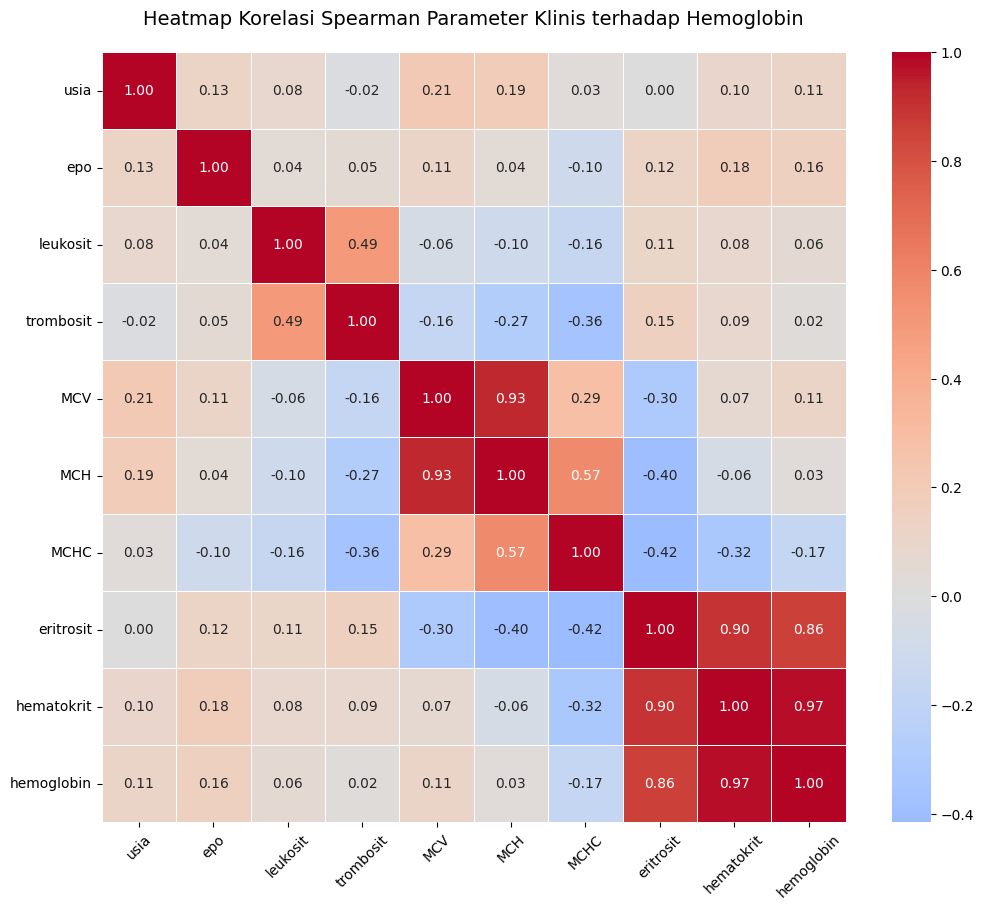

In [30]:
# 1. Tentukan urutan kolom agar target (hemoglobin) berada di paling akhir
# Ini memudahkan pembaca melihat korelasi fitur terhadap target dalam satu baris/kolom
cols_order = ['usia', 'epo', 'leukosit', 'trombosit', 'MCV', 'MCH', 'MCHC', 'eritrosit', 'hematokrit', 'hemoglobin']

# 2. Hitung korelasi Spearman
# Spearman lebih robust terhadap outlier dan hubungan non-linear dibanding Pearson
correlation_matrix = df_clean[cols_order].corr(method='spearman')

# 3. Visualisasi
plt.figure(figsize=(12, 10)) # Ukuran sedikit diperbesar agar angka tidak berhimpitan

# Menggunakan mask untuk menyembunyikan bagian segitiga atas (opsional, agar lebih bersih)
# import numpy as np
# mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

sns.heatmap(
    correlation_matrix, 
    annot=True,          # Menampilkan angka korelasi
    cmap='coolwarm',     # Warna merah (positif), biru (negatif), putih (netral)
    fmt=".2f",           # Dua angka di belakang koma
    linewidths=0.5,      # Memberi jarak antar kotak
    center=0             # Memastikan warna putih berada di angka 0
)

plt.title("Heatmap Korelasi Spearman Parameter Klinis terhadap Hemoglobin", fontsize=14, pad=20)
plt.xticks(rotation=45) # Memutar label X agar mudah dibaca
plt.show()

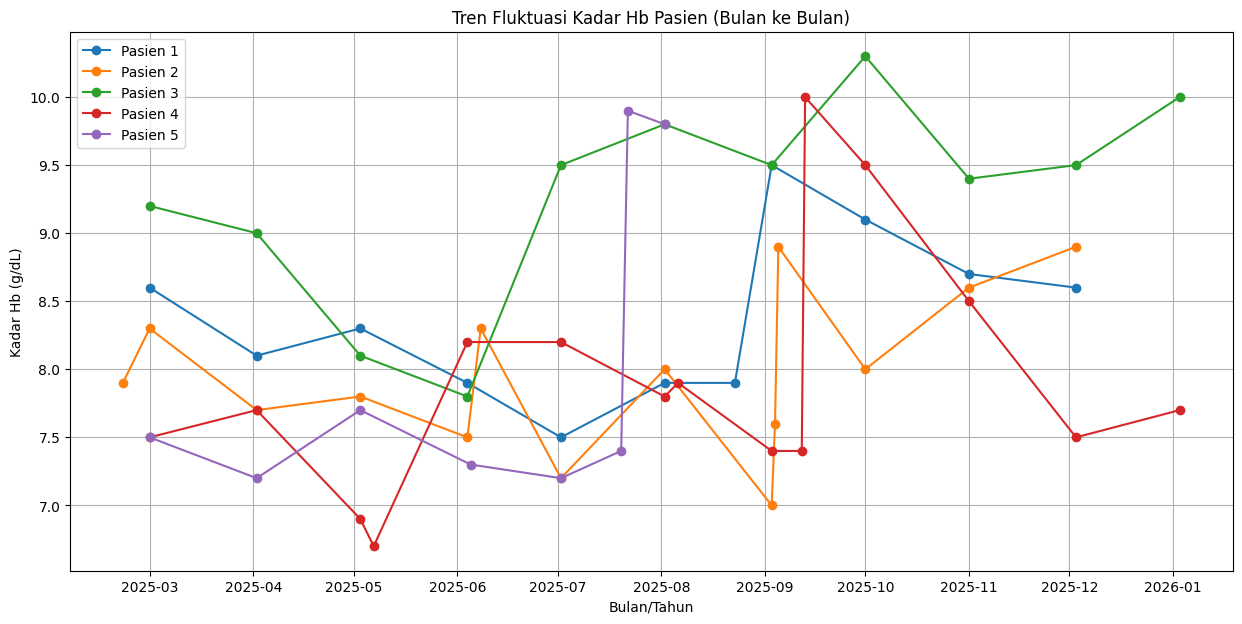

In [31]:
df_clean['tgl_pemeriksaan'] = pd.to_datetime(df_clean['tgl_pemeriksaan'])

# Contoh visualisasi tren Hb untuk 3-5 pasien pertama
plt.figure(figsize=(15, 7))
top_patients = df_clean['id_pasien'].unique()[:5] # Ambil 5 ID pasien pertama 
for patient in top_patients:
    patient_data = df[df['id_pasien'] == patient].sort_values('tgl_pemeriksaan')
    plt.plot(patient_data['tgl_pemeriksaan'], patient_data['hemoglobin'], marker='o', label=f'Pasien {patient}')

plt.title("Tren Fluktuasi Kadar Hb Pasien (Bulan ke Bulan)")
plt.xlabel("Bulan/Tahun")
plt.ylabel("Kadar Hb (g/dL)")
plt.legend()
plt.grid(True)
plt.show()

In [32]:
# plt.figure(figsize=(15, 7))

# # Ambil 5 ID pasien pertama
# top_patients = df_clean['id_pasien'].unique()[:5]

# for i, patient in enumerate(top_patients):
#     # Filter data per pasien
#     patient_data = df_clean[df_clean['id_pasien'] == patient].copy()
    
#     # Set tanggal sebagai index untuk proses resampling
#     patient_data.set_index('tgl_pemeriksaan', inplace=True)
    
#     # Resample per bulan ('MS' = Month Start), ambil rata-rata Hb jika ada >1 pemeriksaan
#     monthly_data = patient_data['hemoglobin'].resample('MS').mean().dropna()
    
#     plt.plot(monthly_data.index, monthly_data.values, marker='o', label=f'Pasien {i+1}')

# plt.title("Tren Rata-Rata Kadar Hb Pasien per Bulan (Data Resampled)")
# plt.xlabel("Tahun-Bulan")
# plt.ylabel("Kadar Hb (g/dL)")
# plt.legend()
# plt.grid(True, linestyle='--', alpha=0.7)
# plt.show()